# TeleCom Churn

No-Churn Telecom is an established Telecom operator in Europe with more than a decade in Business. Due to new players in the market, telecom industry has become very competitive and retaining customers becoming a challenge.
In spite of No-Churn initiatives of reducing tariffs and promoting more offers, the churn rate ( percentage of customers migrating to competitors) is well above 10%.
No-Churn wants to explore possibility of Machine Learning to help with following use cases to retain competitive edge in the industry.
PROJECT GOAL

Help No-Churn with their use cases with ML

1. Understanding the variables that are influencing the customers to migrate.
2. Creating Churn risk scores that can be indicative to drive retention campaigns.
3. Introduce new predicting variable “CHURN-FLAG” with values YES(1) or NO(0) so that email campaigns with lucrative offers can be targeted to Churn YES customers.
4. Exporting the trained model with prediction capability for CHURN-FLAG, which can be highlighted in service applications to serve the customer better.

help to identify possible CHURN-FLAG YES customers and provide more attention in customer touch point areas, including customer care support, request fulfilment, auto categorizing tickets as high priority for quick resolutions any questions they may have etc.,

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from collections import Counter
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from scipy import stats
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

db_host = '18.136.56.185'
username ='dm_team3'
pwd='dm_team15119#'
db_name='project_telecom'


In [2]:
#Connecting to SQL DB
conn =create_engine('mysql+pymysql://'+username+':'+pwd+'@'+db_host+'/'+db_name)
conn.table_names()

OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on '18.136.56.185' (timed out)")
(Background on this error at: http://sqlalche.me/e/e3q8)

In [ ]:
query ='select * from telecom_churn_data '
df =pd.read_sql(query,conn)
df.head(2)

In [ ]:
df.describe
df.info()

In [ ]:
df.columns
df.drop(axis=1 ,columns="columns4",inplace=True)


### Renaming column names

In [ ]:
col_list = ['State' ,'Account_Length','Area_Code','Int_Plan',
             'VMail','VMailMsg','DayMins','DayCalls','DayCharge','EveMins','EveCalls','EveCharge',
             'NightMins','NightCalls','NightCharge','IntMins','IntCalls','IntCharge','CustServCalls' ,'Churn']
df.set_axis(col_list ,axis=1 ,inplace=True)
df.head()

### Getting overview of dataset

In [ ]:
print("Shape :",df.shape)
print ("Rows : " ,df.shape[0])
print ("Columns : ",df.shape[1])
print("\nFeatures : \n" , df.columns.tolist())
print("\n Missing Valus : " ,df.isnull().sum().values.sum())
#print("\nUnique Values : \n" ,df.nunique())

## EDA

In [ ]:
df.dtypes

In [11]:
#Grouping columns into Categorical and Continous colum list
Catcol_list =['State', 'Area_Code','Int_Plan','VMail' ,'Churn']
Concol_list =['Account_Length','VMailMsg','DayMins','DayCalls','DayCharge' ,'EveMins', 'EveCalls',
       'EveCharge', 'NightMins', 'NightCalls', 'NightCharge', 'IntMins','CustServCalls',
       'IntCalls', 'IntCharge']


#### Checking the distribution of data for Continous variables

In [12]:
for i in Concol_list:
    df[i]=df[i].astype('float').astype(int)
df.dtypes

NameError: name 'df' is not defined

In [ ]:
#The numeric columns should be of right datatype before plotting Histogram or Correlation matrix

df[Concol_list].hist(figsize=(20,20))

#### Checking the Data distribution for  Categorical featured

In [ ]:
#plot categorical data using Seaborn's facegrid and Panda's melt function

fig, ax = plt.subplots(1, len(Catcol_list) , figsize=(15, 5))
for i, j in enumerate(df[Catcol_list]):
    df[j].value_counts().plot("bar", ax=ax[i]).set_title(j)
 
fig.show()

#### Checking for any null or empy string values in df

In [10]:
for c in col_list:
    count =df[c].loc[df[c]==''].count()
    count1= df[c].loc[df[c]==np.nan].count()
    print( "Empty strinng values in column '%s' : '%i' " %(c,count ))
    print( "Total count of null values in column '%s' : '%i' " %(c,count1 ))
    print("=========================================")
     
#Hence can be confirmed our data has neithe null values n nor empty tsring values

NameError: name 'col_list' is not defined

In [87]:
for c in Catcol_list:
    #val =Counter( df[c] )
    print("Column '%s' value_counts :  " %(c) , Counter( df[c] )  )
    print("====================================================")
   

Column 'State' value_counts :   Counter({'WV': 149, 'AL': 114, 'MN': 112, 'OH': 110, 'ID': 110, 'NY': 109, 'VA': 109, 'OR': 107, 'NJ': 106, 'WY': 106, 'TX': 105, 'UT': 104, 'WI': 99, 'MI': 98, 'MA': 97, 'KS': 96, 'VT': 95, 'ME': 95, 'MT': 92, 'MD': 92, 'CT': 92, 'CO': 91, 'NH': 91, 'MS': 91, 'RI': 90, 'KY': 90, 'IN': 89, 'DE': 89, 'WA': 89, 'NV': 89, 'FL': 85, 'MO': 84, 'NM': 84, 'SC': 83, 'NC': 83, 'TN': 83, 'DC': 82, 'AZ': 81, 'OK': 80, 'ND': 80, 'NE': 79, 'HI': 79, 'IL': 79, 'GA': 77, 'AR': 77, 'SD': 76, 'LA': 73, 'AK': 69, 'PA': 68, 'IA': 65, 'CA': 44})
Column 'Area_Code' value_counts :   Counter({'415': 2299, '408': 1161, '510': 1157})
Column 'Int_Plan' value_counts :   Counter({' no': 4171, ' yes': 446})
Column 'VMail' value_counts :   Counter({' no': 3381, ' yes': 1236})
Column 'Churn' value_counts :   Counter({' False.': 3961, ' True.': 656})


## Visualise each column wrt Churn

In [88]:
Concol_list =['Account_Length','VMailMsg','DayMins','DayCalls','DayCharge' ,'EveMins', 'EveCalls',
       'EveCharge', 'NightMins', 'NightCalls', 'NightCharge', 'IntMins','CustServCalls',
       'IntCalls', 'IntCharge']

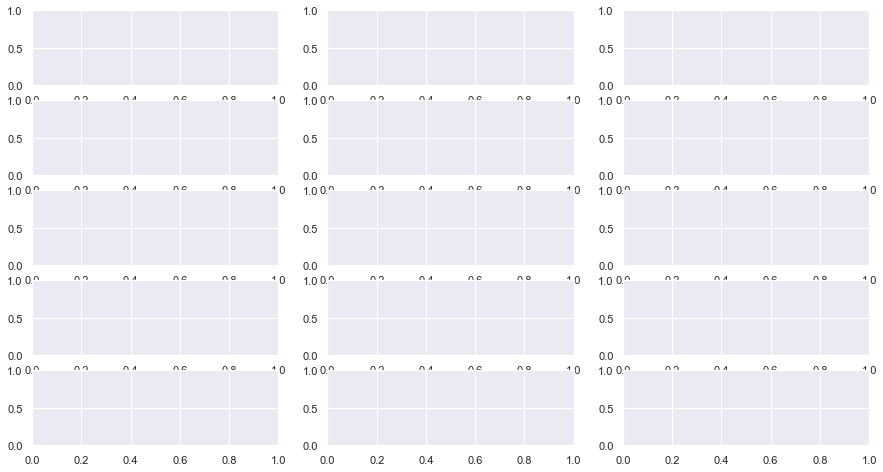

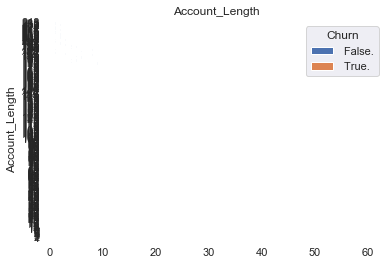

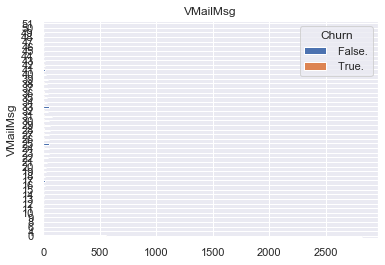

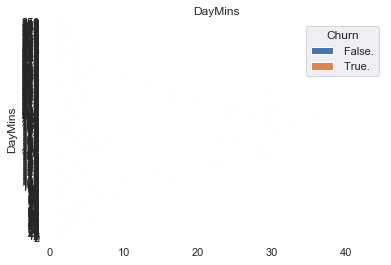

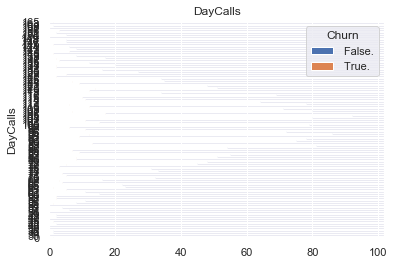

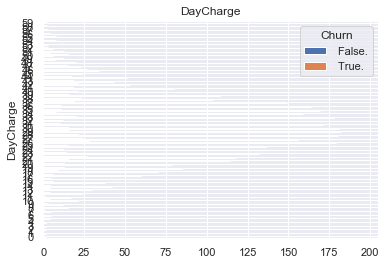

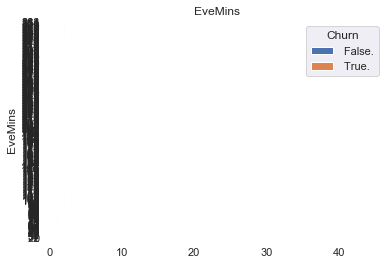

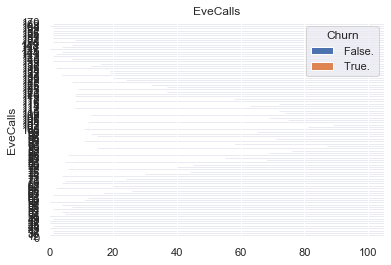

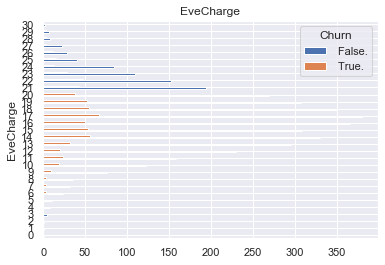

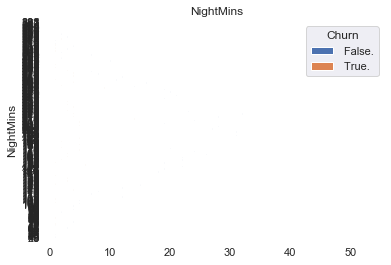

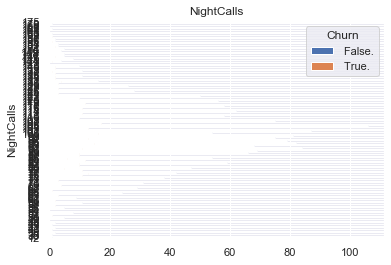

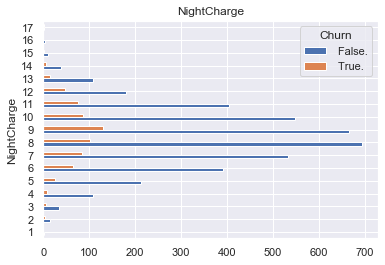

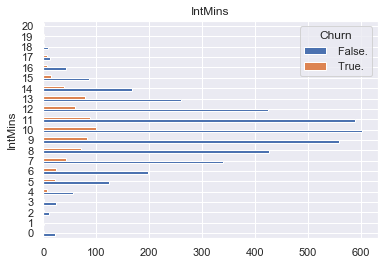

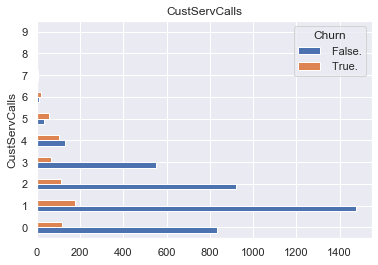

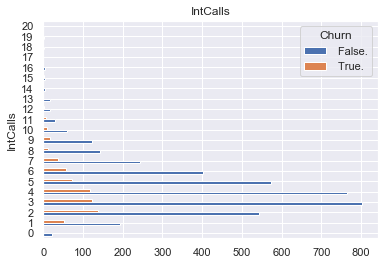

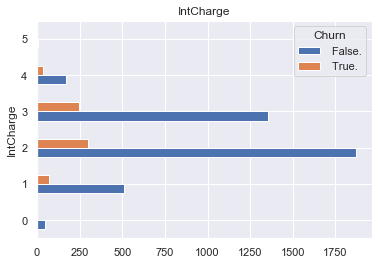

In [95]:
fig, ax = plt.subplots(5,3, figsize=(15, 8))
for i, j in enumerate(df[Concol_list]):
    #df[j].value_counts().plot("bar", ax=ax[i]).set_title(j)
    pd.crosstab(df[j] ,df.Churn).plot(kind='barh').set_title(j)
    
fig.show()
    
    

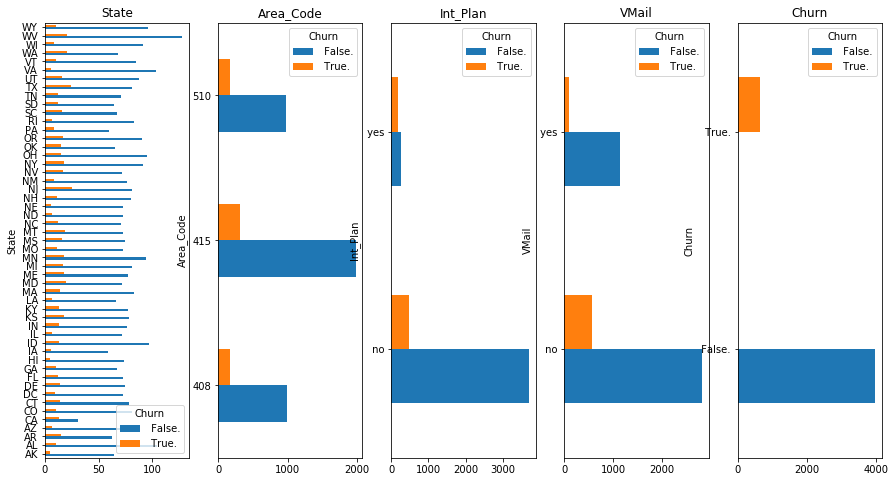

In [23]:
fig, ax = plt.subplots(1, len(Catcol_list) , figsize=(15, 8))
for i, j in enumerate(df[Catcol_list]):
    #df[j].value_counts().plot("bar", ax=ax[i]).set_title(j)
    pd.crosstab(df[j] ,df.Churn).plot(kind='barh',ax=ax[i]).set_title(j)
 
fig.show()

In [24]:
import seaborn as sb
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sb.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sb.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sb.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sb.boxplot(data =df, x=col,ax=ax[2],orient='v')
       
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sb.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

## Correlation

In [25]:
cormat = df.corr()
#print(cor_mat)
plt.figure(figsize= (12,15))
#.heatmap(cor_mat,annot=True)
cormat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Account_Length,VMailMsg,DayMins,DayCalls,DayCharge,EveMins,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntMins,IntCalls,IntCharge,CustServCalls
Account_Length,1,-0.013,0.002,0.033,0.0012,-0.0067,0.016,-0.0061,-0.002,-0.0095,-0.0021,0.00082,0.023,0.0023,0.0026
VMailMsg,-0.013,1,0.0089,-0.0038,0.01,0.018,-0.0065,0.018,0.0046,0.00089,0.003,0.0062,0.0074,0.016,-0.007
DayMins,0.002,0.0089,1,-0.0027,1,-0.01,0.013,-0.0094,0.0096,0.0052,0.0089,-0.013,2.9e-05,-0.013,-0.0081
DayCalls,0.033,-0.0038,-0.0027,1,-0.0024,-0.0065,0.0039,-0.0077,0.011,-0.013,0.01,0.015,0.011,0.012,-0.0087
DayCharge,0.0012,0.01,1,-0.0024,1,-0.0098,0.013,-0.0091,0.0096,0.004,0.0089,-0.013,0.00026,-0.013,-0.0081
EveMins,-0.0067,0.018,-0.01,-0.0065,-0.0098,1,0.0012,1,-0.019,0.014,-0.017,0.00036,0.0056,0.0067,-0.016
EveCalls,0.016,-0.0065,0.013,0.0039,0.013,0.0012,1,0.00035,0.0026,-0.015,0.00098,-0.0042,0.0052,-0.0064,0.0077
EveCharge,-0.0061,0.018,-0.0094,-0.0077,-0.0091,1,0.00035,1,-0.017,0.013,-0.015,0.0039,0.0079,0.0099,-0.016
NightMins,-0.002,0.0046,0.0096,0.011,0.0096,-0.019,0.0026,-0.017,1,0.026,0.99,-0.0041,-0.015,0.0017,-0.014
NightCalls,-0.0095,0.00089,0.0052,-0.013,0.004,0.014,-0.015,0.013,0.026,1,0.027,-0.0041,0.0033,0.0077,-0.01


<Figure size 864x1080 with 0 Axes>

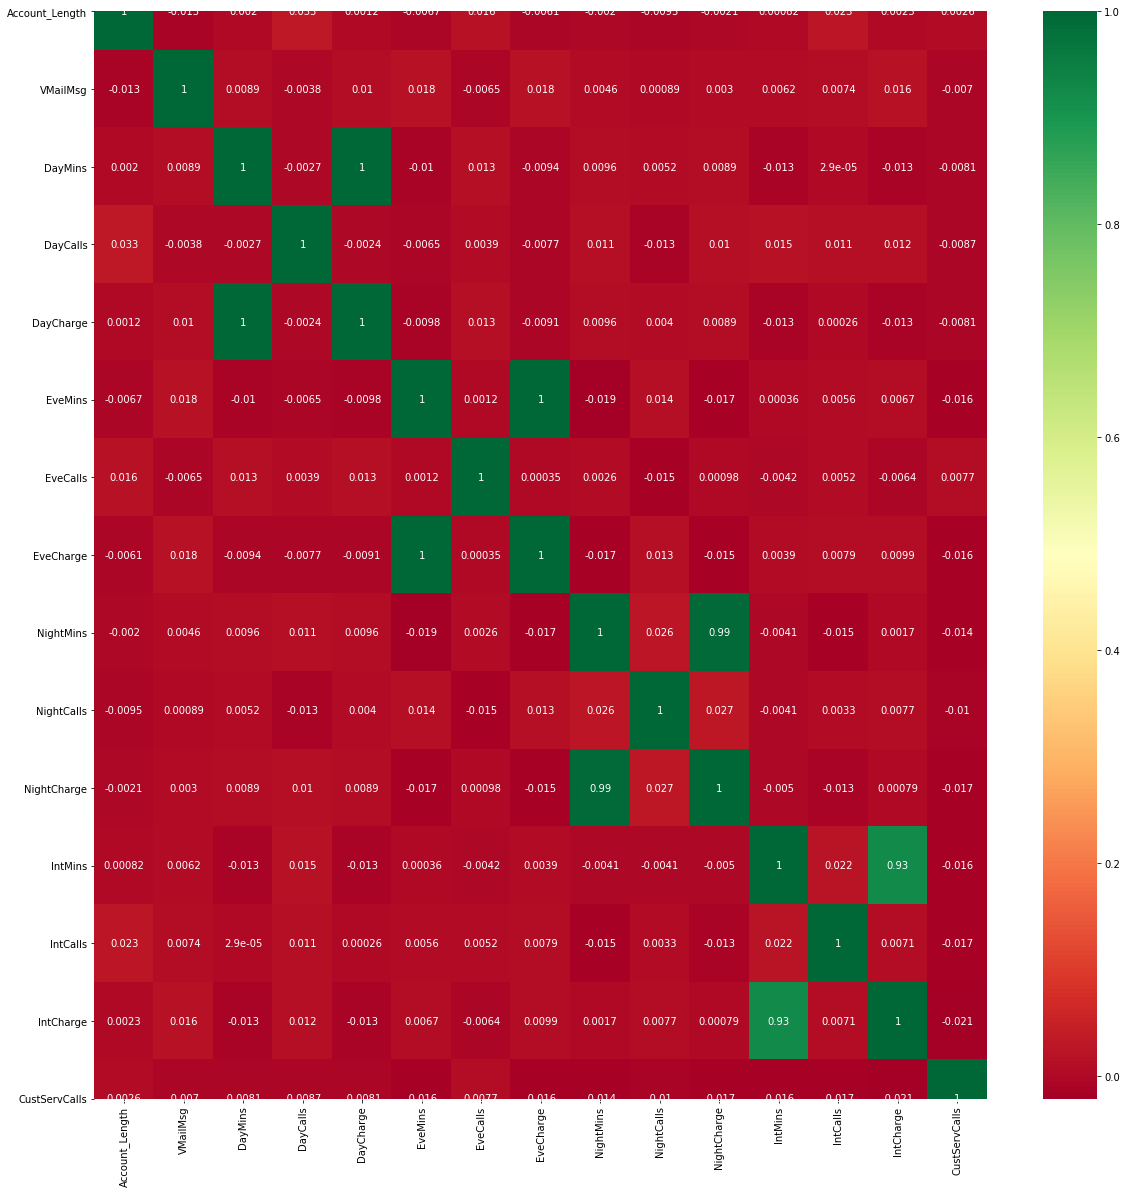

In [26]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sb.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [110]:
df.drop (inplace=True,axis=1 ,columns=['DayMins','EveMins','NightMins','IntMins']) #cant reassign if used inplace=True


In [111]:
df.head()

,State,Account_Length,Area_Code,Int_Plan,VMail,VMailMsg,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntCalls,IntCharge,CustServCalls,Churn
0,16,127,1,0,1,20,74,45,61,16,53,10,3,2,1,0
1,35,106,1,0,1,21,87,27,65,16,65,10,3,3,1,0
2,31,136,1,0,0,0,78,41,72,10,66,6,5,3,0,0
3,35,83,0,1,0,0,35,50,50,5,51,7,7,1,2,0
4,36,74,1,1,0,0,77,28,84,12,83,7,3,2,3,0


## Label Encoding 

In [112]:
from sklearn.preprocessing import LabelEncoder

encoder =LabelEncoder()

for i in df:
    df[i] =encoder.fit_transform(df[i])
df.head(2)

,State,Account_Length,Area_Code,Int_Plan,VMail,VMailMsg,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntCalls,IntCharge,CustServCalls,Churn
0,16,127,1,0,1,20,74,45,61,16,53,10,3,2,1,0
1,35,106,1,0,1,21,87,27,65,16,65,10,3,3,1,0


## Data Split

In [7]:
X = df.iloc[:,:-1]
y = df.Churn

X.head()
X.shape

NameError: name 'df' is not defined

## MultiCollinearity

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df.head()
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,State,3.968967
1,Account_Length,6.942850
2,Area_Code,2.939823
3,Int_Plan,1.112570
4,VMail,11.239713
5,VMailMsg,10.870478
6,DayCalls,10.257071
7,DayCharge,10.450116
8,EveCalls,9.768978
9,EveCharge,13.198761


In [31]:
X_train,X_test,y_train,y_test = tts(X,y ,test_size=0.2 , random_state=10)

# Algorithms for Feature Selection

## PCA

In [90]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
                        
scaler = StandardScaler()

scaler.fit(X_train)

X_train =scaler.transform(X_train)
X_test=scaler.transform(X_test)


In [93]:
from sklearn.decomposition import PCA

for i in col_list:
    pca = PCA(n_components=15)
    X1 = pd.DataFrame( pca.fit_transform(X) )
    
#print(X1.head())   
print( "Explained_variance_ " ,pca.explained_variance_)
print( "Explained_variance_ratio" ,pca.explained_variance_ratio_)

Explained_variance_  [1.55659274e+03 4.01579565e+02 3.88135366e+02 3.85273524e+02
 2.18908212e+02 1.32069985e+02 8.41371435e+01 1.85297005e+01
 6.04068975e+00 5.24375427e+00 1.70597065e+00 6.22398611e-01
 5.01156532e-01 8.68092744e-02 2.37858872e-02]
Explained_variance_ratio [4.86518730e-01 1.25515156e-01 1.21313122e-01 1.20418643e-01
 6.84205588e-02 4.12789549e-02 2.62973706e-02 5.79152539e-03
 1.88803958e-03 1.63895450e-03 5.33207340e-04 1.94532953e-04
 1.56638299e-04 2.71325549e-05 7.43436567e-06]


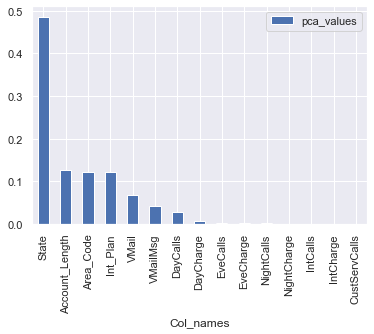

In [94]:
li =pd.DataFrame(data=pca.explained_variance_ratio_ )
li[1] = X.columns
li.columns = ['pca_values' ,'Col_names']
li =li[['Col_names','pca_values']]
li.plot(kind='bar' ,x ='Col_names' ,y='pca_values')

## Univariate Selection by  SelectKBest library

In [34]:
#apply SelectKBest class to extract top best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features = SelectKBest( score_func=chi2 )
f1_model = best_features.fit(X,y)
dfscores = pd.DataFrame(f1_model.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScore =pd.concat( [dfcolumns, dfscores] , axis=1)
featureScore.columns =  ['Specs' ,'Score']
print( featureScore.nlargest(19,'Score'))

             Specs       Score
5         VMailMsg  816.633319
7        DayCharge  530.695327
3         Int_Plan  276.614354
14   CustServCalls  220.546005
4            VMail   41.021084
9        EveCharge   39.700331
1   Account_Length   23.576226
12        IntCalls   13.215160
6         DayCalls    7.810220
11     NightCharge    4.781456
0            State    4.673663
13       IntCharge    2.897685
10      NightCalls    1.326085
2        Area_Code    0.130563
8         EveCalls    0.063010


## ExtraTreesClassifier

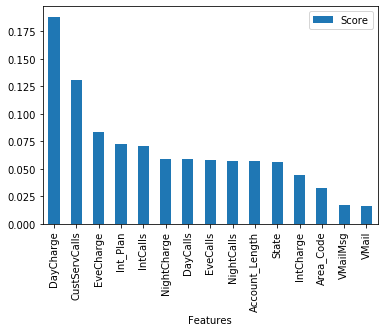

In [35]:
from sklearn.ensemble import ExtraTreesClassifier

f2_model = ExtraTreesClassifier()
f2_model.fit(X,y)
f2_scores = pd.DataFrame( f2_model.feature_importances_  )
f2_df = pd.concat( [dfcolumns ,f2_scores] ,axis=1)
f2_df.columns = ['Features' ,'Score']
f2_df.sort_values(by='Score',ascending =False).plot(kind ='bar', x='Features' ,y='Score')

# Modelling

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , classification_report ,confusion_matrix ,precision_recall_curve ,auc
from sklearn.model_selection import KFold ,cross_val_score

In [37]:
#prepare models

models=[]

models.append(('LR',LogisticRegression()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVM',SVC()))
models.append(('XGBoost',XGBClassifier()))
models.append(('RF',RandomForestClassifier()))

score='accuracy'
results=[]
names=[]

for n ,m in models:
    kfold = KFold(n_splits=10 , random_state=10)
    
    cv_results = cross_val_score(m ,X,y,scoring=score,cv=kfold ) # m :model (model ,X,y,scoring,cv)
    results.append(cv_results)
    names.append(n)
    
    msg ="%s : %f (%f) " % (n,cv_results.mean(),cv_results.std())
    print(msg)

LR : 0.857056 (0.015559) 
KNN : 0.854671 (0.017192) 
CART : 0.900801 (0.010344) 
SVM : 0.857919 (0.016384) 
XGBoost : 0.942605 (0.007379) 
RF : 0.936974 (0.009789) 


In [38]:
model_1 = XGBClassifier(booster='gbtree',
                       random_state=155 ,
                       eta=0.1,
                       max_depth=5 ,
                       gamma=0.03,
                        min_child_weight=1,
                        base_score=0.5,
                        learning_rate=0.1,
                        num_parallel_tree=3
                       )
model_1.fit(X_train,y_train)
y_predict= model_1.predict(X_test)


In [39]:
print("ACCURACY SCORE: " ,accuracy_score(y_test,y_predict).round(2)*100)
print("-------------------------------------------------------------")
print("" ,classification_report(y_test,y_predict))
print("-------------------------------------------------------------")
print("CONFUSION MATRIX: \n " ,pd.crosstab(y_test,y_predict))

ACCURACY SCORE:  96.0
-------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       799
           1       0.95      0.73      0.82       125

    accuracy                           0.96       924
   macro avg       0.95      0.86      0.90       924
weighted avg       0.96      0.96      0.96       924

-------------------------------------------------------------
CONFUSION MATRIX: 
  col_0    0   1
Churn         
0      794   5
1       34  91


### Plot ROC

 XGBoost ROC-AUC Score :  93.0 % 


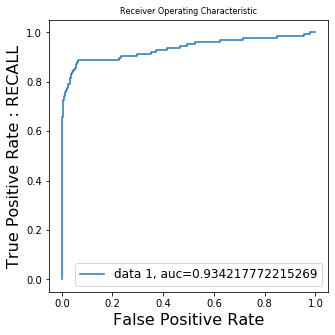

In [40]:
# [:,1] : retrieve just the probabilities for the positive class
y_pred_proba = model_1.predict_proba(X_test)[:,1]

#ROC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test,  y_pred_proba)

#ROC-AUC-Score
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("="*40, "\n",'XGBoost ROC-AUC Score :  %.1f'% (round(auc,2)*100) ,"%" ,"\n","="*40 )

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate : RECALL', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 8)
plt.legend(loc = 'lower right', fontsize = 12)


### Precision_Recall curve  :
 Since its imbalanced dataset ,PRC is efficient compare to ROC

 Precision Recall AUC Score : '88.0'  % 


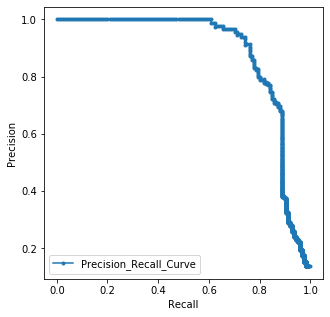

In [41]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.plot(recall, precision, marker='.', label='Precision_Recall_Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

au =metrics.auc(recall,precision)
print( "="*40 ,"\n", "Precision Recall AUC Score : '%.1f' " % (round(au,2)*100) ,"%" ,"\n","="*40)


## Determining Churn Risk Score 
 Can be calculated using predict_proba and defining a new column for that

proba =pd.DataFrame( model_1.predict_proba(X_test)[:,1] ).round(2)

df1 =pd.DataFrame(proba)
df1.columns =['churn_risk_score']

df1['Churn_flag'] =df['Churn']
df1.head()

In [42]:
proba =pd.DataFrame( model_1.predict_proba(X)[:,1] ).round(2)

df1 =pd.DataFrame(proba)
df1.columns =['churn_risk_score']

df['churn_risk_score'] =df1['churn_risk_score']
df.head()

,State,Account_Length,Area_Code,Int_Plan,VMail,VMailMsg,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntCalls,IntCharge,CustServCalls,Churn,churn_risk_score
0,16,127,1,0,1,20,74,45,61,16,53,10,3,2,1,0,0.02
1,35,106,1,0,1,21,87,27,65,16,65,10,3,3,1,0,0.02
2,31,136,1,0,0,0,78,41,72,10,66,6,5,3,0,0,0.02
3,35,83,0,1,0,0,35,50,50,5,51,7,7,1,2,0,0.12
4,36,74,1,1,0,0,77,28,84,12,83,7,3,2,3,0,0.06


In [43]:
X1 = df.iloc[:,:-2]
y1 = df.churn_risk_score

X1.head()
X1.shape

X1_train,X1_test,y1_train,y1_test = tts(X1,y1 ,test_size=0.2 , random_state=10)


In [44]:
from sklearn.ensemble import RandomForestRegressor 

model_2 = RandomForestRegressor(n_estimators = 250,max_depth=20, random_state = 0,criterion='mse',min_samples_split=2)
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(3693, 15)
(3693,)
(924, 15)
(924,)


In [45]:
model_2.fit(X1_train,y1_train)
y_predict2=model_2.predict(X1_test)

mae = metrics.mean_absolute_error(y1_test,y_predict2)
mse = metrics.mean_squared_error(y1_test,y_predict2)
r2score = metrics.r2_score(y1_test,y_predict2)
ex_var =metrics.explained_variance_score(y1_test,y_predict2)
print(mae ,mse ,r2score,ex_var)

print( model_2.score(X1_test,y1_test) )
print( model_2.score(X1_test,y_predict2) )

0.027030017790972062 0.0033486303711901385 0.9527217272719847 0.9527929815075147
0.9527217272719847
1.0


In [46]:
print("RANDOM FOREST REGRESSOR Model Score : %.1f" % (round(model_2.score(X1_test,y1_test),2)*100) ,"%")
print("-------------------------------------------------------------")
print("MEAN ABSOLUTE ERROR : " , mae)
print("-------------------------------------------------------------")
print("MEAN SQUARED ERROR : " ,mse)
print("-------------------------------------------------------------")
print("R2_SCORE: " ,r2score)
print("-------------------------------------------------------------")
print("EXPLAINED VARIENCE SCORE: " ,ex_var)

RANDOM FOREST REGRESSOR Model Score : 95.0 %
-------------------------------------------------------------
MEAN ABSOLUTE ERROR :  0.027030017790972062
-------------------------------------------------------------
MEAN SQUARED ERROR :  0.0033486303711901385
-------------------------------------------------------------
R2_SCORE:  0.9527217272719847
-------------------------------------------------------------
EXPLAINED VARIENCE SCORE:  0.9527929815075147


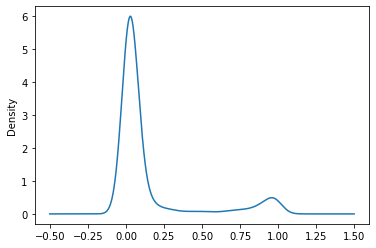

In [49]:
df['churn_risk_score'].plot(kind='kde')

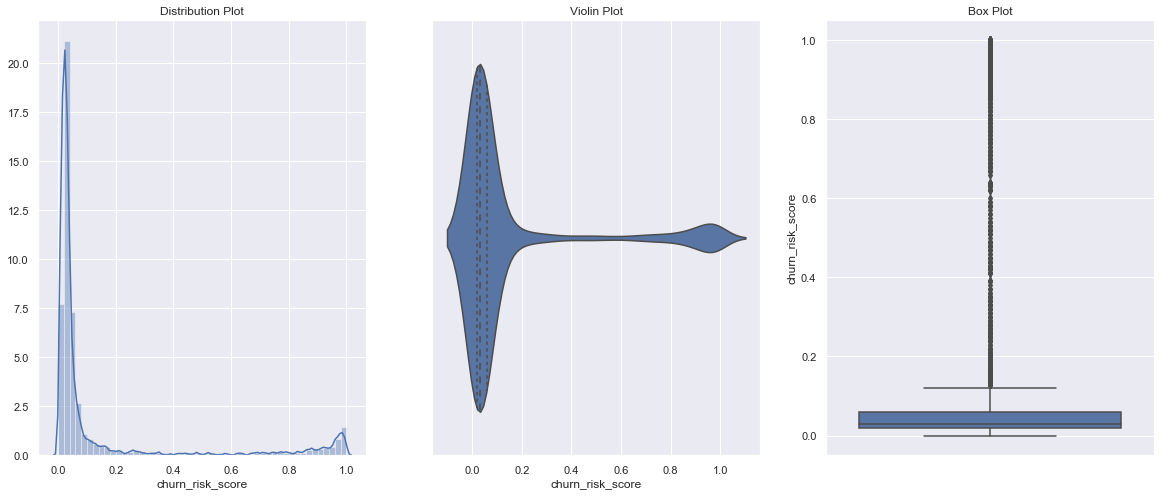

In [533]:
univariate(df=df1,col='churn_risk_score',vartype=0)

In [50]:
df1['New_churnFlag'] = np.where((df1['churn_risk_score'] >= 0.6) ,1 ,0 )
df1['Churn_flag'] = df['Churn']
print("Churn_flag :  \n" ,df1['Churn_flag'].value_counts())
print("New_churnFlag : \n" ,df1['New_churnFlag'].value_counts())

Churn_flag :  
 0    3961
1     656
Name: Churn_flag, dtype: int64
New_churnFlag : 
 0    4112
1     505
Name: New_churnFlag, dtype: int64


 Churn_flag :  Counter({0: 3961, 1: 656})
 New_churnFlag :  Counter({0: 4112, 1: 505}) 


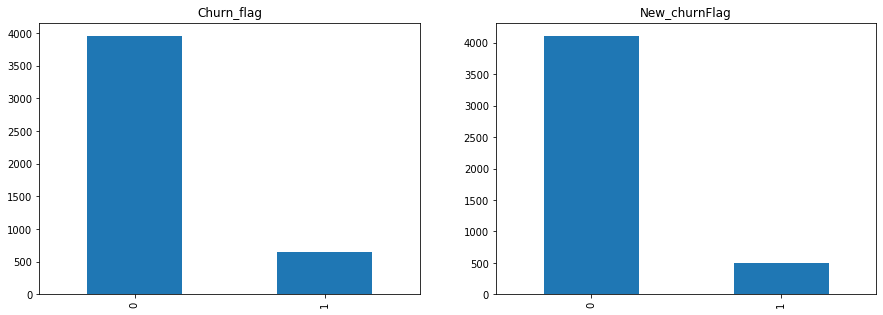

In [51]:
li = ['Churn_flag','New_churnFlag']
fig, ax = plt.subplots(1, len(li) , figsize=(15, 5))
for i, j in enumerate(df1[li]):
    df1[j].value_counts().plot("bar", ax=ax[i]).set_title(j)

print( "="*40 ,'\n',"Churn_flag : " ,Counter(df1['Churn_flag']))
print( "="*40 ,'\n',"New_churnFlag : " ,Counter(df1['New_churnFlag']) , '\n',"="*40)

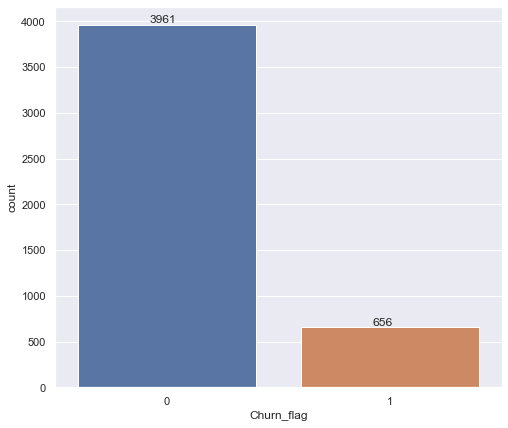

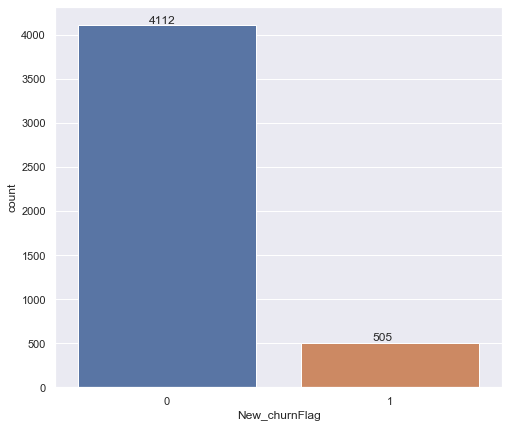

In [52]:
univariate(df=df1,col='Churn_flag',vartype=1)
univariate(df=df1,col='New_churnFlag',vartype=1)

# Smote

### Smote is not improving the accuracy so not considered

In [53]:
from imblearn.over_sampling import SMOTE

sm_model = SMOTE(k_neighbors=3,random_state=100 ,sampling_strategy='minority')
X_train_sm ,y_train_sm = sm_model.fit_sample(X_train,y_train)

Using TensorFlow backend.


In [54]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
                        
scaler = StandardScaler()

scaler.fit(X_train_sm)

X_train_sm =scaler.transform(X_train_sm)
X_train =scaler.transform(X_train)
X_test=scaler.transform(X_test)


In [55]:
grid_model_XGB = XGBClassifier(booster='gbtree',random_state=155,scoring='recall',eta=0.2 ,max_depth=8,
                              min_child_weight=1,
                              base_score=0.5,
                              learning_rate=0.2,
                              num_parallel_tree=2)
grid_model_XGB.fit(X_train_sm,y_train_sm)
y_predict4 = pd.DataFrame(grid_model_XGB.predict(X_test),columns=['Status'])

print(accuracy_score(y_test,y_predict4).round(4)*100)

89.94


In [56]:
print("ACCURACY SCORE After SMOTE: " ,accuracy_score(y_test,y_predict4).round(2)*100)
print("-------------------------------------------------------------")
print("" ,classification_report(y_test,y_predict4))
print("-------------------------------------------------------------")
print("CONFUSION MATRIX: \n " ,confusion_matrix(y_test,y_predict4))

ACCURACY SCORE After SMOTE:  90.0
-------------------------------------------------------------
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       799
           1       0.61      0.74      0.66       125

    accuracy                           0.90       924
   macro avg       0.78      0.83      0.80       924
weighted avg       0.91      0.90      0.90       924

-------------------------------------------------------------
CONFUSION MATRIX: 
  [[739  60]
 [ 33  92]]


# Export model

In [ ]:
import joblib

file_path ='C:\\Users\\Rakshu\\Desktop\\Pyt\\TelecomChurnModel.sav'
joblib.dump( value =model_1, filename=file_path)

In [ ]:
# load the model from disk

loaded_model = joblib.load(file_path)
result = loaded_model.score(X_test, y_test)
print(result)